In [516]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import scipy.integrate as integrate
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import warnings
warnings.filterwarnings("ignore")

In [10]:
df = pd.read_csv('Sweden Load Data 2005-2017.csv')
df.rename({'cet_cest_timestamp':'time','SE_load_actual_tso':'load'},axis='columns',inplace=True)
df['time'] = pd.to_datetime(df['time'],errors='ignore', utc=True)
df['weekday'] = df['time'].dt.weekday

In [619]:
class Env:
    def __init__(self,array_loads,array_weekdays,charge=4,action=None,num=7):
        self.array_loads = array_loads
        self.array_weekdays=array_weekdays
        self.charge = charge
        self.action = action
        self.load_idx = 0
        self.day_idx = 0
        self.collection_actual_load = []
        self.collection_rewards = []
        self.day_actual_load = []
        self.cost_list=[]
        self.reference_list=[]
        self.actual_load=None
        self.reward = 0
        self.episode=0
        self.num=num
        self.queue = [0 for i in range(self.num)]
        
    def increase_load_counter(self):
        self.load_idx+=1
        
    def increase_day_counter(self):
        self.day_idx+=1
        
    def generate_input_load(self):
        self.input_load = self.array_loads[self.load_idx]
        
    def calculate_actual_load(self):
        if self.action==None:
            self.actual_load = self.input_load
            self.collection_actual_load.append(self.actual_load)
            self.increase_load_counter()
            
        elif self.action == 'discharge' and self.charge!=0:
            if self.input_load >= self.collection_actual_load[-1] and self.input_load >= np.mean(self.collection_actual_load[-7:]):
                #self.actual_load = self.collection_actual_load[-1]
                self.actual_load = self.input_load-((100/df['load'].max())*1)
                self.collection_actual_load.append(self.actual_load)
                self.increase_load_counter() 
            else:
                self.actual_load = self.input_load
                self.collection_actual_load.append(self.actual_load)
                self.increase_load_counter()
            self.charge-=1
            
        elif self.action == 'charge' and self.charge!=4:
            if self.input_load <= self.collection_actual_load[-1] and self.input_load <= np.mean(self.collection_actual_load[-7:]):
                #self.actual_load = self.collection_actual_load[-1]
                self.actual_load = self.input_load+((100/df['load'].max())*1)
                self.collection_actual_load.append(self.actual_load)
                self.increase_load_counter()
            else:
                self.actual_load = self.input_load
                self.collection_actual_load.append(self.actual_load)
                self.increase_load_counter()
            self.charge+=1
            
        else:
            self.actual_load = self.input_load
            self.collection_actual_load.append(self.actual_load)
            self.increase_load_counter()
            
    def reward_function_v1(self):
        #reward = -(5+0.5*max(self.collection_actual_load[-25:-1])+0.05*(max(self.collection_actual_load[-25:-1])**2))
        inverted_actual = scaler.inverse_transform([self.collection_actual_load[-25:-1]])[0]
        cost_actual = -(5+0.5*max(inverted_actual)+0.05*(max(inverted_actual)**2))
        inverted_input = scaler.inverse_transform([self.array_loads[self.load_idx-25:self.load_idx-1]])[0]
        cost_input = -(5+0.5*max(inverted_input)+0.05*(max(inverted_input)**2)) 
        self.cost_list.append(cost_actual)
        self.reference_list.append(cost_input)
        reward = (abs(cost_input) - abs(cost_actual))
        return reward
    
    def reward_function_v2(self):
        x = [0,1] 
        f = [self.array_loads[self.day_idx-1],self.array_loads[self.day_idx]]
        g = [self.collection_actual_load[self.day_idx-1],self.collection_actual_load[self.day_idx]]
        input_area = integrate.simps(f, x)
        actual_area = integrate.simps(g, x)
        reward = np.abs(input_area-actual_area)*10
        return reward
    
    
    def calculate_reward(self):
        self.increase_day_counter()
        if self.array_weekdays[self.day_idx] == self.array_weekdays[self.day_idx-1]:
            self.reward = 0
            self.collection_rewards.append(self.reward)
        else:
            #cost function
            self.reward = self.reward_function_v1()
            self.collection_rewards.append(self.reward)
            self.episode+=1

In [693]:
class PolicyNetwork(nn.Module):
    """
    PGN-Policy Gradient Network (Function Approximator):
    
    - input size: number of observation states in environment
    - n_actions: number of actions in environment
    
    We will use neural network with one hidden layer, which 
    has one hidden layer with 128 neurons and ReLU activation function, 
    as was described in report. So, our vector of \theta parameters 
    will have 128 elements. 
    
    """
    # initialization function
    def __init__(self, input_size, n_actions):
        super(PolicyNetwork, self).__init__()
        
        #torch.manual_seed(3)
        # Creating a simple neural network with 128 parameters \theta
        # in one hidden layer 
        # Softmax activation will be done in the algorithm later.
        self.net = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 126),
            nn.ReLU(),
            nn.Linear(126, n_actions),
            #nn.Softmax(dim=1)
        )
    # forward propagation function
    def forward(self, x):
        return self.net(x)

In [583]:
def compute_q_vals(rewards):
    """
    rewards: list of rewards collected in episode
    """
    res = []
    sum_r = 0.0
    # looping through the list of rewards in reverse order
    # because in REINFORCE (look at report pseudocode)
    # last action receives one last reward, pre-last action
    # receives pre-last reward plus discounted last etc.:
    for r in reversed(rewards):
        sum_r *= 0.99
        sum_r += r
        res.append(sum_r)
    # we againg reverse our list of rewards per action
    # in the order actions appeared
    return list(reversed(res))

In [584]:
eps = np.finfo(float).eps
#array_loads = df['load'].diff(24).diff(24*7).diff(24*7*4).diff(24*7*4*12)
array_loads = df['load']
array_weekdays = df['weekday']+1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
new_data = scaler.fit_transform(array_loads.values[:, np.newaxis])
new_data = new_data.reshape(1,-1)[0]
array_loads = new_data

In [744]:
def main(lr,clip_grad=False):
    if clip_grad:
        CLIP_GRAD=0.1
    #STARTING EPISODE
    env1 = Env(array_loads,array_weekdays)
    env1.generate_input_load()
    env1.calculate_actual_load()

    loss_list=[]
    action_list=[]
    norm_grad_list = []
    mean_rewards_list = []
    torch.manual_seed(0)
    net = PolicyNetwork(1, 3)

    optimizer = optim.Adam(net.parameters(), lr=lr)

        #create list for collecting total rewards
    total_rewards = []

    map_action = {0:'discharge',1:'charge',2:'wait'}

    batch_states, batch_actions, batch_qvals = [], [], []
    cur_rewards = []
    #number of episodes (days) used for 1 backprop
    n=120
    np.random.seed(0)
    #years of data for pass
    for i in range(24*7*4*12*years):
        obs = np.array([env1.actual_load])
        obs_v = torch.FloatTensor(obs)
        batch_states.append(obs)
        logits_v = net(obs_v)
        probs = F.softmax(logits_v).detach().numpy()
        action = np.random.choice(np.array([0,1,2]),p=np.array(probs).round(4))
        env1.action=map_action[action]
        action_list.append(env1.action)
        env1.generate_input_load()
        env1.calculate_actual_load()
        env1.calculate_reward()
        batch_actions.append(np.array([action]))
        cur_rewards.append(env1.reward)
        if env1.episode<n:
            continue

        cur_rewards = np.array(cur_rewards)
        #cur_rewards = (cur_rewards - cur_rewards.mean()) / (cur_rewards.std()+eps)
        total_rewards.append(sum(cur_rewards)/n)
        mean_reward = float(np.mean(total_rewards[-7:]))
        mean_rewards_list.append(mean_reward)
        optimizer.zero_grad()
        batch_qvals.extend(compute_q_vals(cur_rewards))
        cur_rewards=list(cur_rewards)
        cur_rewards.clear()

        states_v = torch.FloatTensor(batch_states)
        batch_actions_t = torch.LongTensor(batch_actions)
        batch_qvals_v = torch.FloatTensor(batch_qvals)

        # neural network, log softmax, q_vals * log_softmax, loss, backprop
        logits_v = net(states_v) 
        log_prob_v = F.log_softmax(logits_v, dim=1)
        out, _ = torch.max(batch_actions_t,dim=1)
        log_prob_actions_v = batch_qvals_v*log_prob_v[range(len(batch_states)),out]
        loss_v = -log_prob_actions_v.mean()
        #loss_list.append(loss_v)  
        loss_v.backward()
        #nn.utils.clip_grad_norm_(net.parameters(), CLIP_GRAD)
        optimizer.step()

        #let's find grads and grads norm and variance
        grads = np.concatenate([p.grad.data.cpu().numpy().flatten()
                                                        for p in net.parameters()
                                                        if p.grad is not None])
        norm_grad = np.linalg.norm(grads)
        norm_grad_list.append(norm_grad)
        batch_states.clear()
        batch_actions.clear()
        batch_qvals.clear()
        env1.episode = 0
    return env1,mean_rewards_list,norm_grad_list

In [631]:
torch.save(net.state_dict(), 'strange_model.pt')

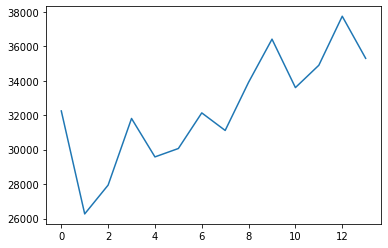

In [675]:
plt.plot(np.arange(len(mean_rewards_list)),mean_rewards_list)
plt.show()

Random Agent

In [689]:
def main_random(seed):
    env1 = Env(array_loads,array_weekdays)
    env1.generate_input_load()
    env1.calculate_actual_load()

    loss_list=[]
    action_list=[]
    norm_grad_list = []
    mean_rewards_list = []

    net = PolicyNetwork(1, 3)

    total_rewards = []

    map_action = {0:'discharge',1:'charge',2:'wait'}

    batch_states, batch_actions, batch_qvals = [], [], []
    cur_rewards = []
    n=120
    #5 years of data
    np.random.seed(seed)
    for i in range(24*7*4*12*5):
        obs = np.array([env1.actual_load])
        obs_v = torch.FloatTensor(obs)
        batch_states.append(obs)
        logits_v = net(obs_v)
        probs = F.softmax(logits_v).detach().numpy()
        action = np.random.choice(np.array([0,1,2]),p=np.array(probs).round(4))
        env1.action=map_action[action]
        action_list.append(env1.action)
        env1.generate_input_load()
        env1.calculate_actual_load()
        env1.calculate_reward()
        batch_actions.append(np.array([action]))
        cur_rewards.append(env1.reward)
        if env1.episode<n:
            continue  
        cur_rewards = np.array(cur_rewards)
        #cur_rewards = (cur_rewards - cur_rewards.mean()) / (cur_rewards.std()+eps)
        total_rewards.append(sum(cur_rewards)/n)
        mean_reward = float(np.mean(total_rewards[-7:]))
        mean_rewards_list.append(mean_reward)
        batch_qvals.extend(compute_q_vals(cur_rewards))
        cur_rewards=list(cur_rewards)
        cur_rewards.clear()
        batch_states.clear()
        batch_actions.clear()
        batch_qvals.clear()
        env1.episode = 0
    return env1,mean_rewards_list

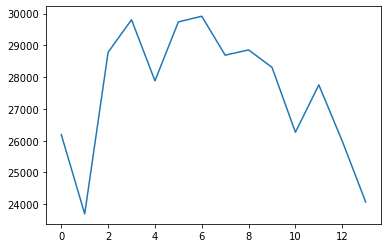

In [690]:
plt.plot(np.arange(len(mean_rewards_list)),mean_rewards_list)
plt.show()